Lectura: Higher-order neural networks --- 15:00 min
===

* Última modificación: Marzo 10, 2022

In [1]:
import warnings

warnings.filterwarnings("ignore")

A partir del modelo del perceptró continuo y aplicando técnicas de preprocesamiento, es posible obtener otros modelos de redes neuronales que han recibido atención por parte de profesionales e investigadores en la literatura. 

En este caso, se demuestra como obtener un modelo de red de propagación hacia adelante que está compuesta por una sola capa oculta y cuyas entradas están conformadas por la transformación polinomial de las variables independientes.

## Definición

Esta es una red neuronal que tiene la forma básica de un perceptrón continuo; la diferencia radica en que hay entradas adicionales que computan polinomios de alto orden para las entradas.

$$
y = \sigma
(
w_0 + \sum_i w_i x_i + \sum_{ij} w_{ij} x_i x_j + \cdots
)
$$

## Caso de aplicación

In [2]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/concrete.csv",
    sep=",",  
    thousands=None,
    decimal=".",
)  

df.head()

cement   slag  ash  water  superplastic  coarseagg  fineagg  age  strength
0   540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28     79.99
1   540.0    0.0  0.0  162.0           2.5     1055.0    676.0   28     61.89
2   332.5  142.5  0.0  228.0           0.0      932.0    594.0  270     40.27
3   332.5  142.5  0.0  228.0           0.0      932.0    594.0  365     41.05
4   198.6  132.4  0.0  192.0           0.0      978.4    825.5  360     44.30

## Preparación de los datos

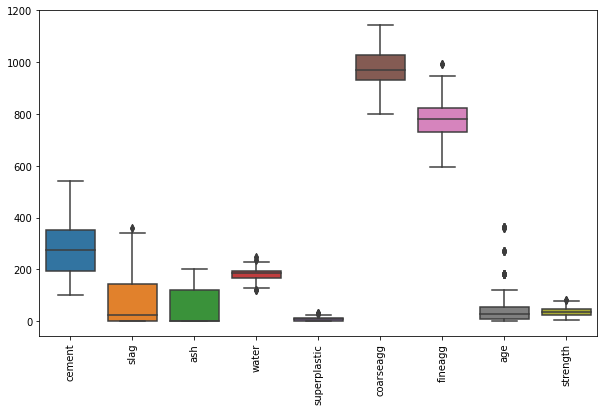

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#
# Los rangos de las variables numéricas son
# bastantes diferentes
#
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90);

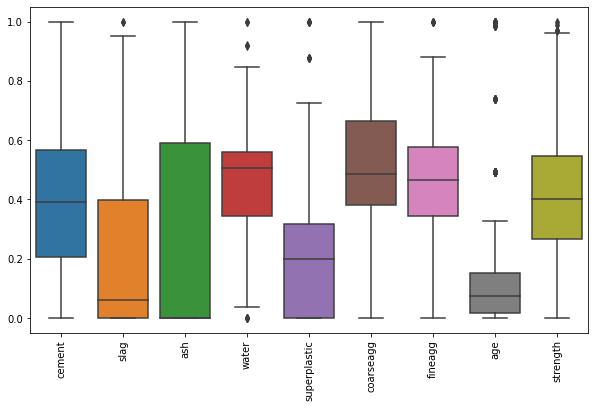

In [4]:
from sklearn.preprocessing import MinMaxScaler

#
#  Se escalan todas las variables al rango [0, 1]
#  para evitar problemas asociados a la escala
#
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_norm)
plt.xticks(rotation=90);

## Modelo

In [9]:
import numpy as np

class ContinuousPerceptron:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 batch=False,         # ?batch o online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.batch = batch
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        history = []

        if self.batch is True:
            for epoch in range(self.max_epochs):
                u = np.dot(X, self.coef_) + self.intercept_
                s = 1. / (1. + np.exp(-u))
                e = d - s
                self.coef_ += 2 * self.learning_rate * np.sum((X.T * e * s * (1. - s)).T, axis=0)
                self.intercept_ += 2 * self.learning_rate * np.sum((e * s * (1. - s)).T, axis=0)
                history.append(sum([a**2 for a in e]))
        else:

            for epoch in range(self.max_epochs):

                if self.shuffle is True:
                    n = list(range(X.shape[0]))
                    np.random.shuffle(n)
                    X = X[n,:]
                    d = d[n]

                for i in range(X.shape[0]):
                    u = np.dot(X[i,:], self.coef_) + self.intercept_
                    s = (1. / (1. + np.exp(-u)))
                    e = (d[i] - s)[0]
                    self.coef_ += 2 * self.learning_rate * e * s * (1-s) * X[i,:]
                    self.intercept_ += 2 * self.learning_rate * e * s * (1-s)
                    history.append(e**2)

        return history

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return 1. / (1. + np.exp(-u))

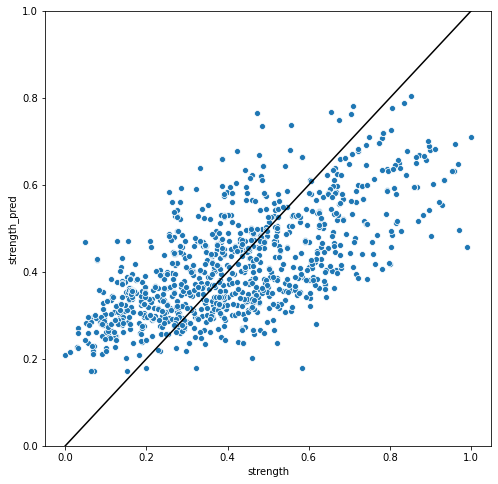

In [10]:
#
# Datos originales del dataset
#
X_train = df_norm.drop(columns="strength")
y_train = df_norm.strength

#
#
from sklearn.preprocessing import PolynomialFeatures

#
# En este caso, la expansión polinomial se realiza mediante
# el preprocesamiento de los datos
#
poly = PolynomialFeatures(2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)

#
# Es una red de una capa que se simula como un perceptrón
# simple
#
nn = ContinuousPerceptron()
nn.fit(X_train_poly, y_train)

df_norm["strength_pred"] = nn.predict(X_train_poly)

plt.figure(figsize=(8, 8))
sns.scatterplot(x="strength", y="strength_pred", data=df_norm)
plt.plot([0, 1], [0, 1], color="black")
plt.ylim(0, 1)
plt.show()